### Task 4: Decision trees for regression
For the final task, we'll implement a class TreeRegressor for regression with decision trees.

In [ ]:
# installing the required libraries
import sklearn
from sklearn import datasets
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Following standard practice in scikit-learn, we inherit from the class BaseEstimator,
# which is the base class of all classifiers and regression models:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from abc import ABC, abstractmethod # import abstract class for DecisionTree and abstract method for functions

In [ ]:
#conda install graphviz

In [ ]:
#conda install -c anaconda graphviz

In [ ]:
!pip install graphviz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from graphviz import Digraph

Below we have the components needed to implement decision tree classifiers and regression models: DecisionTreeLeaf and DecisionTreeBranch.

A leaf corresponds to the base case of a recursion. It is a "dummy" tree that always returns a constant value.

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value # e.g. flower class of iris, or owns a car/not own car

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

A branch will look at one feature, and will select a subtree depending on the value of the feature. That subtree will then be called recursively to compute the prediction.

This implementation assumes that the feature is numerical. Depending on whether the feature is or isn't greater than a threshold, the "high" or "low" subtree will be selected.

In [ ]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x): # x is the feature value to look at
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

We write the DecisionTree class as an abstract class that contains the functionality common to all types of decision trees. The regression subclass will be implemented below.

In [ ]:
# general decision tree algo that can be inherited by both regression and classification subclasses

class DecisionTree(ABC, BaseEstimator): 

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth ## MAX DEPTH ##
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training - X and Y will also be subsets of data after splits
    def make_tree(self, X, Y, max_depth):

        # DIFFERENT FOR CLASSIFICATION / REGRESSION
        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        ## MAX DEPTH ##
        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0: # FIRST TERMINATION CASE - reaching max depth
            return DecisionTreeLeaf(default_value)

        # DIFFERENT FOR CLASSIFICATION / REGRESSION
        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y): # SECOND TERMINATION CASE - when all y values are the same no need to go further
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold (if numerical value in feature). 
        # To rank the "usefulness" of features, we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

The functions that the subclasses will need to implement, and which are done differently for classification and regression, are the following:

- get_default_value: what output value to use if we decide to return a leaf node. For classification, this will be the most common output value, while for regression it will be the mean.
- is_homogeneous: tests whether a set of output values is homogeneous. For classification, this means that all outputs are identical; for regression, we'll probably test whether the variance is smaller than some threshold.
- best_split: finds the best splitting point for that feature. For classification, this will be based on one of the classification criteria (information gain, gini impurity, majority sum); for regression, it will be based on variances in the subsets.

Below is the subclass that implements decision tree regression.

Here, we define the various criteria we can use to find the "quality" of a split in terms of how homogeneous the subsets are. See the reading material for the mathematical definitions of these criteria:

In [ ]:
## REGRESSION CRITERION
def compute_variance(data):
    """Compute and returns variance for a given set of data points"""
    n = len(data)
    variance = ((1/n)*(np.sum(np.power(data,2)))) - ((1/np.power(n,2))*(np.power(np.sum(data),2)))
    return variance

def variance_reduction(tot_var,high_var,low_var,n,nh,nl):
    """Compute and returns variance reduction for a given set of data points and its subset"""
    var_red = (tot_var) - ((nh/n)*high_var) - ((nl/n)*low_var)
    return var_red

#### Step 1. Implementing the regression model

It is probably a good idea to structure this in a similar way to the TreeClassifier, just adapted for regression instead. 
- This means that you should probably write a new subclass that inherits from the same abstract superclass DecisionTree that the classifier used. 
- Probably it's a good idea to replace ClassifierMixin with RegressorMixin (this just replaces the default type of evaluation metric).

In your regressor subclass, implement the same methods that you can see in TreeClassifier. In particular, you'll need to define:

1. What it means for a set of output values to be **"homogeneous"**: instead of checking whether all values are identical, you should probably compare the variance to some threshold. (This threshold can either be a small value that you hard-code, or a user-specified hyperparameter.) The NumPy function np.var is probably useful here.
2. How to compute the **default output value**: you should return the mean instead of the most common value. Here, you can use np.mean.
3. How to select the **best split** that leads to the most homogeneous subsets.

The third of these items is the most challenging. In the cases of regression, we use the variance of a set of values to measure its homogeneity. The homogeneity criterion most typically used in decision tree regression (including scikit-learn's implementation) is the following, called "variance reduction":

![Picture title](image-20220119-212859.png)

Here, V(S) means the variance of the full set of values, V(SH) means the variance of the higher part, nH means the size of the higher part, etc.

To implement this splitting function, you can get some inspiration from the corresponding function for the classifier. The basic structure will be very similar. But instead of counting the number of instances of each class (using the Counter), you'll have to compute variances instead.

Hint. Computing the variances from scratch at each possible threshold, for instance by calling np.var, will be time-consuming if the dataset is large. (What is the time complexity?) It's better to rely on the formula:

![Picture title](image-20220119-210127.png)

When you go through the possible thresholds, keep track of the sum and sum of squares for the lower and upper partitions.

http://www.cse.chalmers.se/~richajo/dit866/assignments/a1/assignment1.html

Below is the given calculation on variance from the extra reading on deicison tree statinng variance should be smaller than threshold.

![Picture title](image-20220119-205210.png)

http://www.cse.chalmers.se/~richajo/dit866/lectures/l1/decision_trees.pdf

In [ ]:
class TreeRegression(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=50, criterion='maj_sum', threshold=0.2):
        super().__init__(max_depth)
        self.criterion = criterion
        self.threshold = threshold
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        elif self.criterion == 'var_red':
            self.criterion_function = variance_reduction
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    ### 1. UPDATED ###
    # Select a default value that is going to be used if we decide to make a leaf.
    # Instead of using the most frequent value, as for classification,
    # we now use the mean value of the output Y.
    def get_default_value(self, Y):
        #self.class_distribution = Counter(Y)
        #return self.class_distribution.most_common(1)[0][0]
        return np.mean(Y)
    
    ### 2. UPDATED ###
    # Checks whether a set of output values is homogeneous. In the regression case, 
    # compare the variance to some threshold. (This threshold can either be a small value that you hard-code, 
    # or a user-specified hyperparameter.) The NumPy function np.var is probably useful here.
    # For one of the base cases in the recursion, we now check whether the variance in the
    # output Y is smaller than some threshold ε, instead of checking whether all outputs are identical.
    def is_homogeneous(self, Y):
        # calculate variance
        variance = compute_variance(Y)
        # check if variance is smaller than threshold
        if variance < self.threshold: # if smaller return true, else false
            return True
        else:
            return False

    ### 3. UPDATED ### 
    # Finds the best splitting point for a given feature. We'll count variance 
    # for the low and high parts, then compute the variance reudction
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature]) # creates list of sorted items showing their index    
        X_sorted = list(X[sorted_indices, feature]) # sors X by same index list as above, but actual value
        Y_sorted = list(Y[sorted_indices]) # sorts Y by same index list as above, but actual value

        n = len(Y) #use in formula to calculate variance, and for iteration of all positions

        # Placeholders for high and low subsets variances
        low_var = 0
        high_var = 0
        tot_var = compute_variance(Y) #use in formula to calculate variance reduction

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(1, n-1):
            
            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_i = X_sorted[i]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue
                
            # update variance for high and low subsets at current index
            low_var = compute_variance(Y_sorted[:i])
            high_var = compute_variance(Y_sorted[i:])
            
            # count items (len) of low and high subsets to use in variance reduction
            nl = len(Y_sorted[:i]) 
            nh = len(Y_sorted[i:])
               
            # Compute the homogeneity criterion for a split at this position
            var_reduction = self.criterion_function(tot_var,high_var,low_var,n,nh,nl)

            # If this is the best split, remember it.
            if var_reduction > max_score:
                max_score = var_reduction
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        
        return max_score, feature, split_point

#### Step 2. Sanity check

The following function will generate a small number of training examples for a simple regression task with one input variable.

For the report. If you consider the data-generating function, what kind of decision tree would we want to describe this data?

Train your decision tree regressor algorithm on a small dataset generated by the function above, and then draw the tree. Select the tree depth according to your common sense. Does the result make sense? What happens if we allow the tree depth to be a large number?

In [ ]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

n = 100
Xdummy,Ydummy = make_some_data(n)

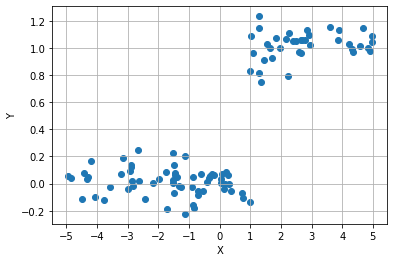

In [ ]:
def scatter(x,y):
    plt.scatter(x,y)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xticks(range(-5,6,1))
    plt.grid()
    plt.show()

scatter(Xdummy,Ydummy)

##### Comments:
The type of decision tree that would describe this data well is a decision tree for regression, which is used for data sets where the target variable Y is of continous value (numeric) and not discrete (categorical) where we'd use a decision tree for classification instead.

The result seems to make sense since the natural split, when plotting the data in a scatter plot, is just around 1 on the x-axis and from the plotted tree we can see that the threshold of the feature is also approximately 1. 

If the data points are above the threshold the model will predict a y-value of approximately 1 which seems to corresponds well to an average of  where the upper right cluster is positioned on the y-axis. Likewise we can see that if the data points are below the threshold they are predicted a y-value of around 0, which also corresponds to where the lower left cluster i spositioned on the y-axis on average.

Independantly of the max depth given (when we tested up to a max depth of 10) the tree dosen't go beyond 1 level with 100 data points having only one feature.


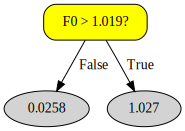

In [ ]:
# set values for hyperparameters to be used in model
threshold = 0.2
criterion = 'var_red'
max_depth = 10

reg1 = TreeRegression(max_depth, criterion, threshold) #create object from class
reg1.fit(Xdummy, Ydummy) # train the model with the dummy data
reg1.draw_tree() # draw the tree

#### Step 3. Predicting apartment prices using decision tree regression

Train and evaluate a decision tree regression model for the Russian apartment price prediction example.

For the report. In your submitted report, please describe what tree depth you used and the evaluation score you got on the test set.

In [ ]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
#alldata_shuffled.head(3)
#Xtrain.info()

In [ ]:
def best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest):
    """
    Tests different depth of tree and returns model, 
    along with accuracy scores for test and train for all depths
    """
    # empty lists to store accuracy score for train and test
    scores_train = [] 
    scores_test = []
    
    #test depth between 1-10 (inclusive)
    for i in range(min_d, max_d): 
        model = TreeRegression(max_depth=i, criterion='var_red', threshold=0.2) #create object from class
        model.fit(Xtrain, Ytrain) #train (fit) the model with training data

        # cross_validate with n folds and get MSE (mean square error) from all folds
        train_nmse = cross_validate(model, Xtrain, Ytrain, scoring='neg_mean_squared_error')
        train_mse = -train_nmse['test_score'].mean()

        # check MSE for test set
        test_mse = mean_squared_error(Ytest, model.predict(Xtest))

        scores_train.append(train_mse)
        scores_test.append(test_mse)
    
    return scores_train, scores_test

# set min and max tree depth
min_d = 1 #min tree depth
max_d = 21 #max tree depth

train_mse, test_mse = best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest)

In [ ]:
best_mse = min(test_mse)
best_depth = test_mse.index(min(test_mse))+1

# print result
#print("Train MSE:\n",train_mse)
#print("Test MSE:\n",test_mse)
print("---\nBest MSE for Test data was",best_mse,"with a max depth of",best_depth)

---
Best MSE for Test data was 0.2875546387838707 with a max depth of 6


In [ ]:
def plot_train_test_accuracy(min_range, max_range, train_scores, test_scores):
    plt.figure(figsize=(10,6))
    plt.plot(range(min_range,max_range), train_scores, label = "Train", color='green')
    plt.plot(range(min_range,max_range), test_scores, label = "Test", color='blue')
    plt.title("Train vs. Test MSE by Tree Depth")
    plt.xlabel("Tree Depth")
    plt.ylabel("MSE")
    plt.legend()
    plt.xticks(range(min_range,max_range,1))
    plt.grid()
    plt.show()

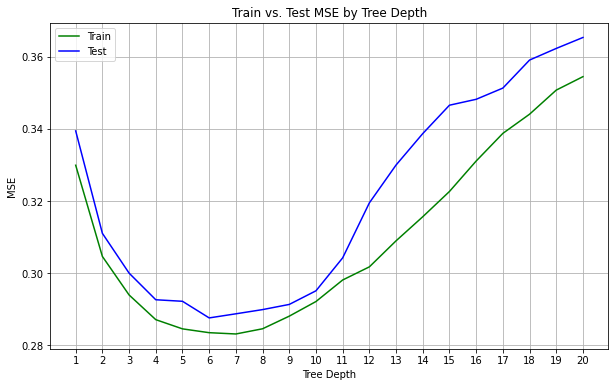

In [ ]:
plot_train_test_accuracy(min_d, max_d, train_mse, test_mse)

##### Comments:

Here we evaluated the max tree depth bewtween 1 and 20 to understand the behaviours. The final selected depth we'd use is 6 based on the result from the mean square error score generated from the test data and visualized in the graph (by the blue line) above. The green line represents the mean MSE score from a 5-fold cross validation on the training data.

#### Step 4. Underfitting and overfitting

For the apartment price prediction task, draw a plot that shows the evaluation score on the training set and on the test set for different values of max_depth, ranging from 0 to 12. (It's probably easiest if you implement a function to draw this plot, but it's also OK if you draw the plot by hand.)

Clarification. When computing the evaluation scores for the training set, do not use cross-validation this time! We are investigating overfitting now.

For the report. Please include this plot in the report, and comment on the differences between the two curves.

In [ ]:
def best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest):
    """
    Tests different depth of tree and returns model, 
    along with accuracy scores for test and train for all depths
    """
    # empty lists to store accuracy score for train and test
    scores_train = [] 
    scores_test = []
    
    #test depth
    for i in range(min_d, max_d): 
        model = TreeRegression(max_depth=i, criterion='var_red', threshold=0.2) #create object from class
        model.fit(Xtrain, Ytrain) #train (fit) the model with training data

        # get MSE for models on train and test
        train_mse = mean_squared_error(Ytrain, model.predict(Xtrain))
        test_mse = mean_squared_error(Ytest, model.predict(Xtest))

        scores_train.append(train_mse)
        scores_test.append(test_mse)
    
    return scores_train, scores_test

# set min and max tree depth
min_d2 = 1 #min tree depth
max_d2 = 13 #max tree depth

train_mse2, test_mse2 = best_model_depth(min_d2, max_d2, Xtrain, Ytrain, Xtest, Ytest)

In [ ]:
best_mse2 = min(test_mse2)
best_depth2 = test_mse2.index(min(test_mse2))+1

# print result
#print("Train MSE:\n",train_mse2)
#print("Test MSE:\n",test_mse2)
print("---\nBest MSE for Test data was",best_mse2,"with a max depth of",best_depth2)

---
Best MSE for Test data was 0.2875546387838707 with a max depth of 6


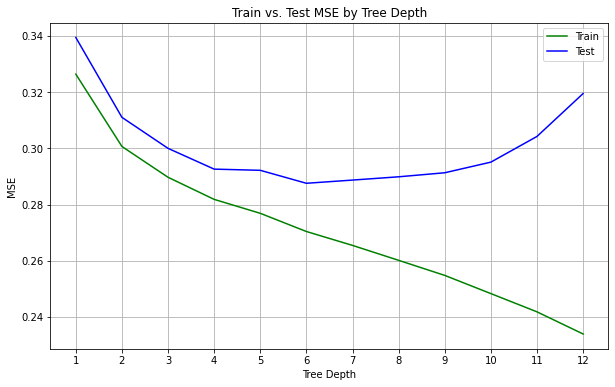

---
Best MSE for Test data was 0.2875546387838707 with a max depth of 6


In [ ]:
plot_train_test_accuracy(min_d2, max_d2, train_mse2, test_mse2)
print("---\nBest MSE for Test data was",best_mse2,"with a max depth of",best_depth2)

##### Comments:
As seen in the above chart the blue line represent the mean squared error for the test data while the green line represents the training data. The x-axis shows the max tree depth tested. 

Ideally we'd like to have a minimum value for our evaluation score (minimum mean square error). As seen in the graph for the test data we found that score at a max depth of 6. However, the green line continues to decrease as the max depth of the tree increases while the blue line does the opposite.  The behaviour of the green line can be explained by that the models starts to memorize the training data and start to overfit when the maximum depth of the tree growns larger. 